In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

from Config.CustomConfig import BalloonConfig
from data.CustomDataset import BalloonDataset
from model.MaskRcnn import MaskRCNN
from Utils import visualize

In [2]:
# Training dataset
dataset_train = BalloonDataset()
dataset_train.load_balloon('D:\DataSet\\balloon', "train")
dataset_train.prepare()

# Validation dataset
dataset_val = BalloonDataset()
dataset_val.load_balloon('D:\DataSet\\balloon', "val")
dataset_val.prepare()

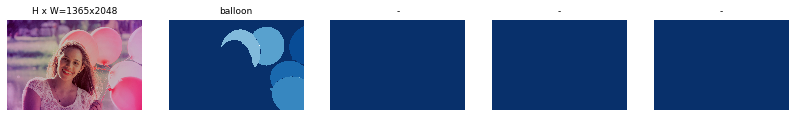

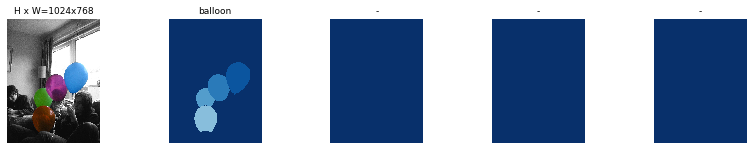

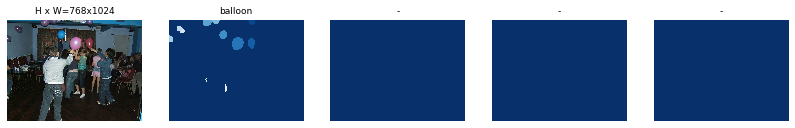

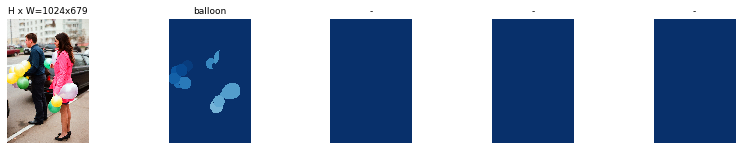

In [4]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
config = BalloonConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
ROOT_DIR = 'D:\\coursera\\maskrcnn'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "checkpoint")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrain\\mask_rcnn_coco.h5")

In [9]:
model = MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
    )
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [11]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\coursera\maskrcnn\checkpoint\balloon20200607T1319\mask_rcnn_balloon_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

D:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
  2/100 [..............................] - ETA: 1:45:09 - loss: 3.4223 - mean_1: 0.1272 - mean_2: 0.5413 - mean_3: 0.5562 - mean_4: 0.8659 - mean_5: 1.3318

KeyboardInterrupt: 

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=60, 
            layers="all")

In [ ]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn_ballon.h5")
model.keras_model.save_weights(model_path)

inference

In [ ]:
from Utils.sample_utils import color_splash

In [ ]:
class InferenceConfig(BalloonConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

model = MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

In [ ]:
model_path = 'D:/coursera/maskrcnn/checkpoint/mask_rcnn_ballon.h5'
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Validation dataset
dataset_val = BalloonDataset()
dataset_val.load_balloon('D:\DataSet\\balloon', "val")
dataset_val.prepare()

In [ ]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]

In [ ]:
splash = color_splash(image, r['masks'])